In [1]:
import tensorflow as tf
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import models
from tensorflow.keras.layers import AveragePooling2D
from sklearn.model_selection import train_test_split


In [3]:
Image_size = 256
Batch_size = 32
Channels = 3
Epochs = 5

In [4]:
df = tf.keras.preprocessing.image_dataset_from_directory('data/',
                                                        shuffle=True,
                                                        image_size = (Image_size, Image_size),
                                                        batch_size= Batch_size)

Found 7553 files belonging to 2 classes.


In [5]:
class_names = df.class_names
class_names

['with_mask', 'without_mask']

In [6]:
len(df)

237

In [7]:
237 *32 # which is near to the total of the data

7584

In [8]:
for image_batch, label_batch in df.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1]


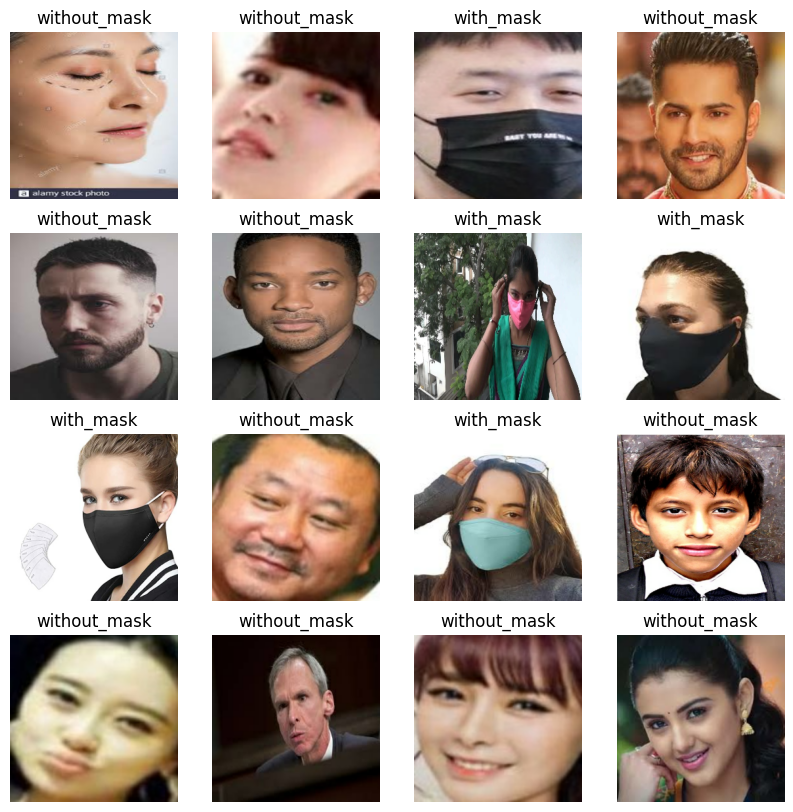

In [9]:
plt.figure(figsize=(10, 10))

for image_batch, label_batch in df.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(df)

In [12]:
len(train_ds), len(val_ds), len(test_ds)

(189, 23, 25)

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(Image_size, Image_size),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [16]:
input_images = (Batch_size, Image_size, Image_size, Channels)
n_classes=2

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_images),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_images)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [18]:
model.compile(
    optimizer= 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds, 
    validation_data = val_ds,
    epochs = Epochs,
    batch_size=Batch_size,
    verbose=1
)

Epoch 1/5
189/189 [==============================] - 156s 455ms/step - loss: 0.3735 - accuracy: 0.8358 - val_loss: 0.5376 - val_accuracy: 0.7473
Epoch 2/5
189/189 [==============================] - 50s 263ms/step - loss: 0.2864 - accuracy: 0.8840 - val_loss: 0.5768 - val_accuracy: 0.7147
Epoch 3/5
189/189 [==============================] - 43s 226ms/step - loss: 0.2514 - accuracy: 0.8966 - val_loss: 0.4147 - val_accuracy: 0.7921
Epoch 4/5
189/189 [==============================] - 50s 264ms/step - loss: 0.2385 - accuracy: 0.9066 - val_loss: 0.5936 - val_accuracy: 0.7092
Epoch 5/5
189/189 [==============================] - 48s 253ms/step - loss: 0.2085 - accuracy: 0.9206 - val_loss: 0.4921 - val_accuracy: 0.7541


In [20]:
scores = model.evaluate(test_ds)
scores

25/25 [==============================] - 31s 66ms/step - loss: 0.4830 - accuracy: 0.7685


[0.48296618461608887, 0.768530547618866]

In [21]:
len(history.history['accuracy'])

5

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validationg accuracy')

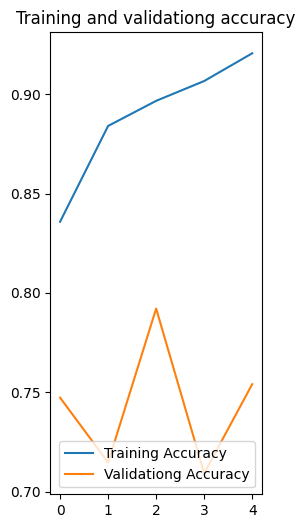

In [23]:
plt.figure(figsize=(6,6))
plt.subplot(1, 2, 1)
plt.plot(range(Epochs), acc, label='Training Accuracy')
plt.plot(range(Epochs), val_acc, label='Validationg Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validationg accuracy')

First image to predict : 
Actual label with_mask
1/1 [==============================] - 1s 1s/step
[0.08334409 0.9166559 ]
1


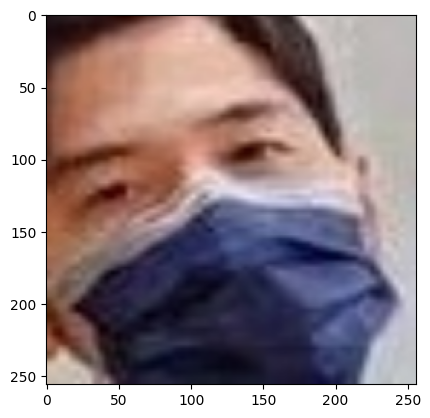

In [24]:
import numpy as np

for image_batch, label_batch in test_ds.take(1):
    first_image= image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print('First image to predict : ')
    plt.imshow(first_image)
    print('Actual label', class_names[first_label])
    
    batch_prediction  = model.predict(image_batch)
    print((batch_prediction[0]))
    print(np.argmax(batch_prediction[0]))

In [25]:
def predict(model, img):
    img_array =  tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 77ms/step


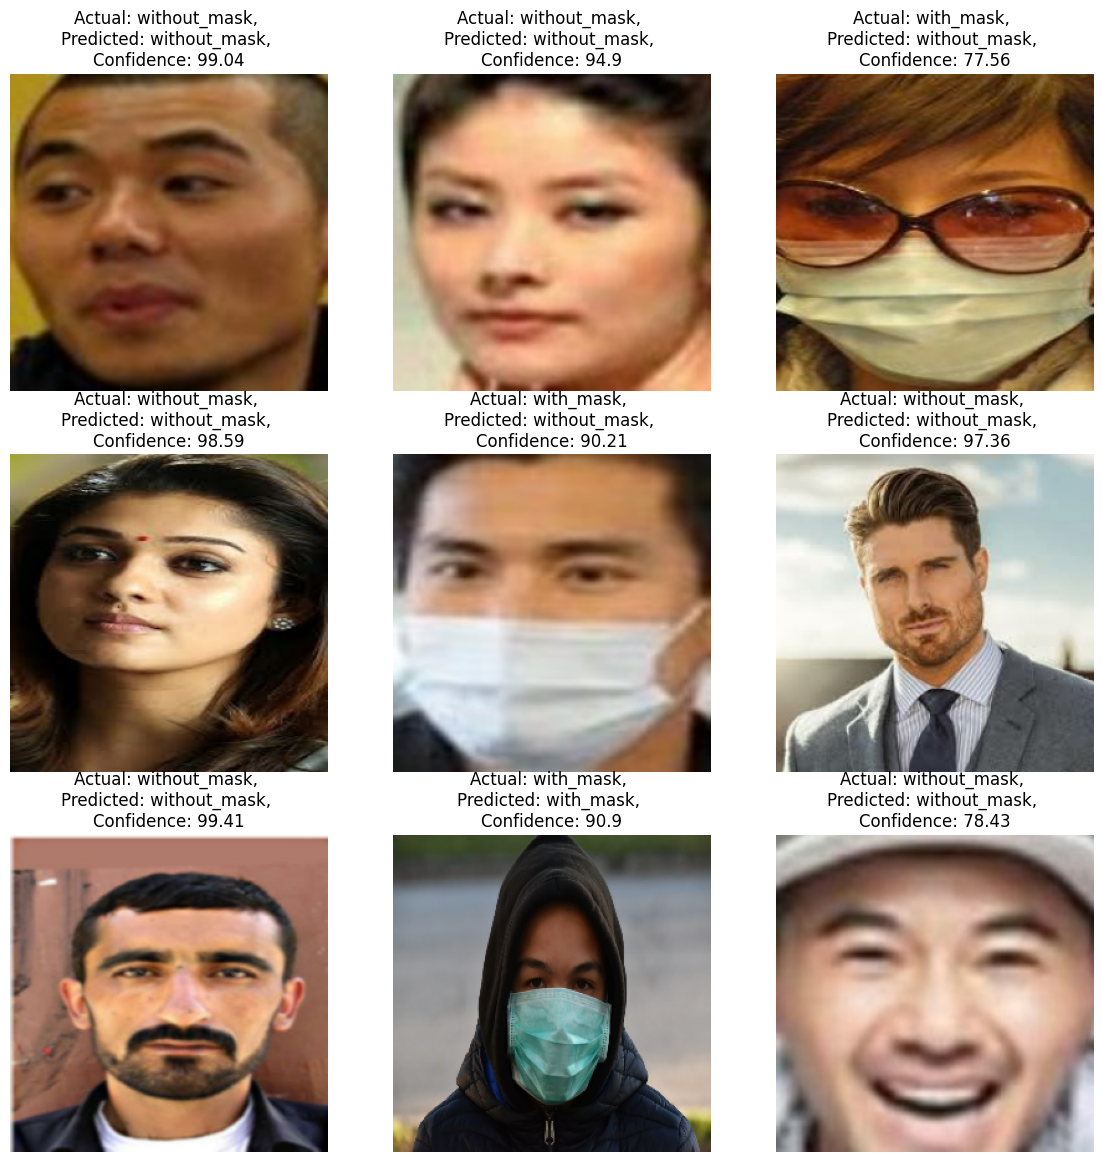

In [26]:
plt.figure(figsize=(14, 14))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f'Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}')
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')

In [27]:
class_names

['with_mask', 'without_mask']

In [28]:
def predict_inputted_pic(model, img2):
    plt.imshow(img2)
    plt.axis('off')

    img_array =  tf.keras.preprocessing.image.img_to_array(img2)
    img_array = tf.expand_dims(img_array, 0) # create a batch
    
    predictions = model.predict(img_array)
    predictions = np.argmax(predictions)
    return predictions
